# **Spam Detection using Deep Learning Algorithms**

>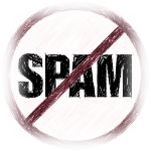

This notebook consists of evaluation of deep learning algorithms like LSTM and biLSTM with and without hyperparameters. The models are evaluated to find the best algorithm for the given dataset and given task. The dataset is taken from Kaggle.com. 
The goal is to find  the algorithm with maximum accuracy and minimum loss.

Also, each model is tested with an actual spam email I received to my inbox. It is observed that all the models detect the spam message accurately.

## Importing All the dependencies

In [161]:
import tensorflow as tf

In [162]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,GlobalMaxPooling1D, Input, LSTM, Embedding,Dropout,Bidirectional
import re as re

## Importing the dataset and preprocessing
Dataset taken from : https://www.kaggle.com/venky73/spam-mails-dataset

In [163]:
df=pd.read_csv('spam_ham_dataset.csv', encoding='ISO-8859-1')

In [164]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [165]:
df = df.drop(["Unnamed: 0"], axis=1)
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [166]:
#removing html elements from the text column
def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
df['text']=df['text'].apply(lambda cw : remove_tags(cw))
df['text']=df['text'].replace('\n',' ', regex=True)
df['text']=df['text'].replace('\r',' ', regex=True)
df['text']=df['text'].replace('Subject:',' ', regex=True)
df['text']=df['text'].replace('nbsp',' ', regex=True)
df['text']=df['text'].replace('re :',' ', regex=True)
df.head()

,label,text,label_num
0,ham,enron methanol ; meter # : 988291 this is a...,0
1,ham,"hpl nom for january 9 , 2001 ( see attached...",0
2,ham,"neon retreat ho ho ho , we ' re around to t...",0
3,spam,"photoshop , windows , office . cheap . main ...",1
4,ham,indian springs this deal is to book the t...,0


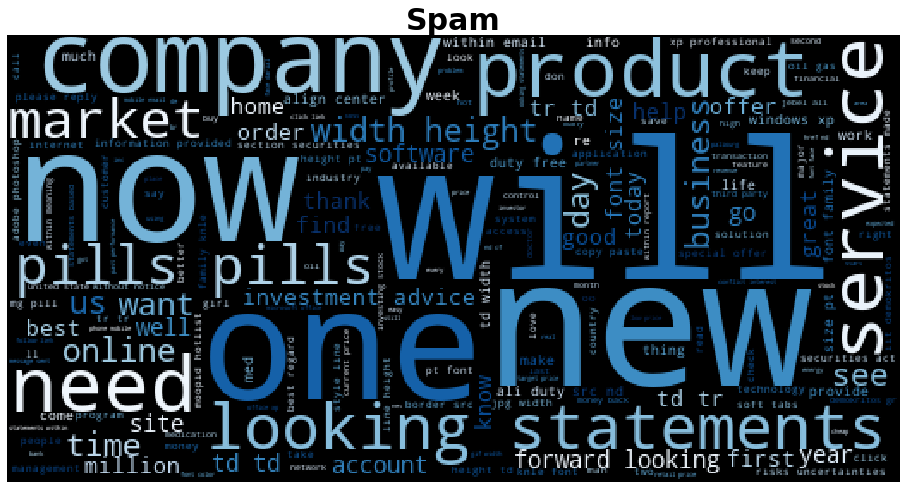

In [167]:
# spam
spam_message_df=df[df.label=="spam"]
ham_message_df=df[df.label=="ham"]
ham_messages=" ".join(spam_message_df.text.to_numpy().tolist())
spam_messages=" ".join(ham_message_df.text.to_numpy().tolist())
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
ham_wordcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,  colormap='Blues').generate(ham_messages)
plt.figure(figsize=(16,10))
plt.imshow(ham_wordcloud, interpolation='nearest')
plt.title('Spam',fontweight='bold',fontsize=30)
plt.axis('off') # turn off axis
plt.show()

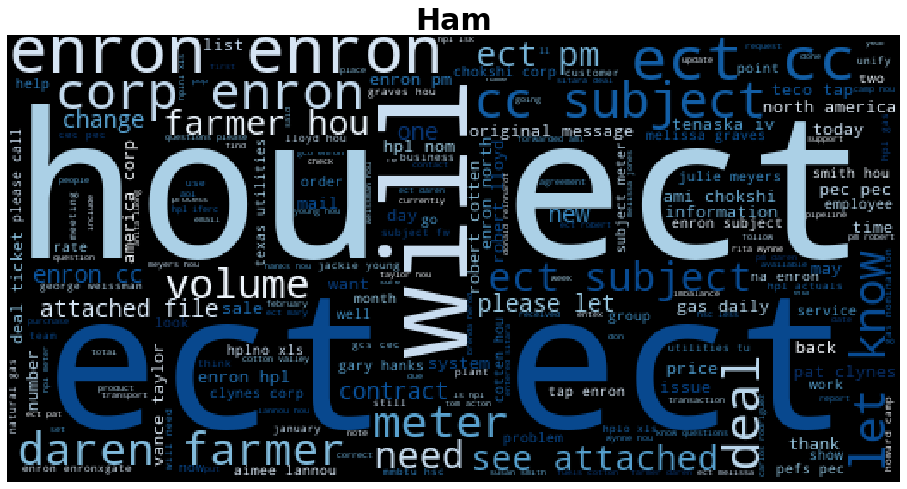

In [168]:
#wordclouds ham
ham_messages=" ".join(df[df.label=="ham"].text.to_numpy().tolist())
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
ham_wordcloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,  colormap='Blues').generate(ham_messages)
plt.figure(figsize=(16,10))
plt.imshow(ham_wordcloud, interpolation='nearest')
plt.title('Ham',fontweight='bold',fontsize=30)
plt.axis('off') # turn off axis
plt.show()

In [169]:
df.head()

,label,text,label_num
0,ham,enron methanol ; meter # : 988291 this is a...,0
1,ham,"hpl nom for january 9 , 2001 ( see attached...",0
2,ham,"neon retreat ho ho ho , we ' re around to t...",0
3,spam,"photoshop , windows , office . cheap . main ...",1
4,ham,indian springs this deal is to book the t...,0


In [170]:

Y = df['label_num'].values

In [171]:
x_train,x_test,y_train,y_test=train_test_split(df['text'],Y,test_size=0.33)

In [172]:
MAX_VOCAB_SIZE = 20000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train=tokenizer.texts_to_sequences(x_train)
sequences_test=tokenizer.texts_to_sequences(x_test)

In [173]:
type(x_test)

pandas.core.series.Series

In [174]:
# get word -> integer mapping
tokenidx = tokenizer.word_index
V = len(tokenidx)
print('%s unique tokens.' % V)

41034 unique tokens.


In [175]:
## Padding to get input of the form NxT for LSTM
x_train_pad=pad_sequences(sequences_train)
print('Shape x_train_pad:', x_train_pad.shape)

T=x_train_pad.shape[1]
x_test_pad=pad_sequences(sequences_test, maxlen=T)
print('Shape x_test_pad:', x_test_pad.shape)

Shape x_train_pad: (3464, 4482)
Shape x_test_pad: (1707, 4482)


LSTM model training

In [176]:
#embedding dimension vectors and indexing the vector
D=20

#Hidden vector M
M=15

i=Input(shape=(T,))

#V+1 as 0th place is not used due to value for missing tokens
X=Embedding(V+1,D)(i)
X=LSTM(M,return_sequences=True)(X)
X=GlobalMaxPooling1D()(X)
X=Dense(1,activation='sigmoid')(X)

model=Model(i,X)

In [177]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
r=model.fit(x_train_pad,y_train,validation_data=(x_test_pad,y_test),epochs=10)

Epoch 1/10
109/109 [==============================] - 45s 394ms/step - loss: 0.5913 - accuracy: 0.6983 - val_loss: 0.4009 - val_accuracy: 0.7206
Epoch 2/10
109/109 [==============================] - 42s 386ms/step - loss: 0.3363 - accuracy: 0.8992 - val_loss: 0.1947 - val_accuracy: 0.9625
Epoch 3/10
109/109 [==============================] - 44s 408ms/step - loss: 0.1378 - accuracy: 0.9783 - val_loss: 0.1446 - val_accuracy: 0.9731
Epoch 4/10
109/109 [==============================] - 43s 391ms/step - loss: 0.0722 - accuracy: 0.9925 - val_loss: 0.1247 - val_accuracy: 0.9731
Epoch 5/10
109/109 [==============================] - 42s 382ms/step - loss: 0.0571 - accuracy: 0.9916 - val_loss: 0.1158 - val_accuracy: 0.9713
Epoch 6/10
109/109 [==============================] - 42s 383ms/step - loss: 0.0394 - accuracy: 0.9948 - val_loss: 0.1470 - val_accuracy: 0.9566
Epoch 7/10
109/109 [==============================] - 42s 382ms/step - loss: 0.0287 - accuracy: 0.9962 - val_loss: 0.1232 - val_ac

Evaluation

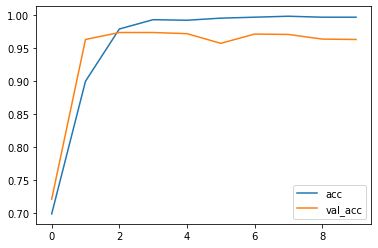

In [178]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

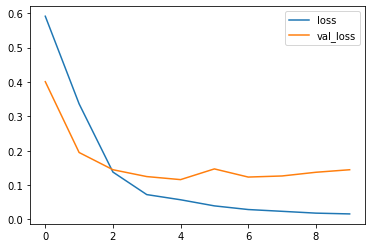

In [179]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [180]:
model.evaluate(x_test_pad, y_test)

54/54 [==============================] - 8s 149ms/step - loss: 0.1446 - accuracy: 0.9625


[0.144551083445549, 0.9625073075294495]

In [181]:
predict_msg = ["DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt"]

## Testing the model with real data

In [182]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =T)
    print("\033[1m Message:\033[0m "+str(predict_msg[0]))
    return ("This message is a: " +np.where(model.predict(padded)>0.5,"Spam","Ham")[0][0])
predict_spam(predict_msg)

 Message: DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt


'This message is a: Spam'

## **Improving the model**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


40.822440087145964

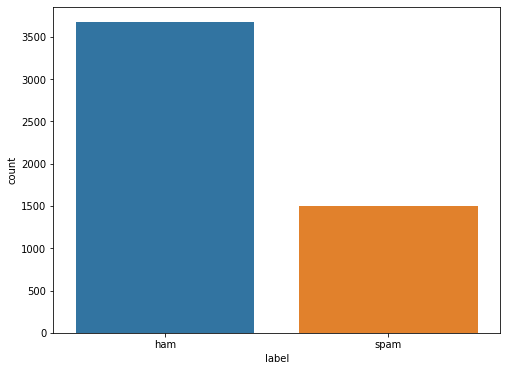

In [183]:
# we can observe imbalance data here 
import seaborn as sns
plt.figure(figsize=(8,6))
sns.countplot(df.label)
# Percentage of spam messages
(len(spam_message_df)/len(ham_message_df))*100 # 15.48%

# **Downsampling**

(1499, 3) (1499, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


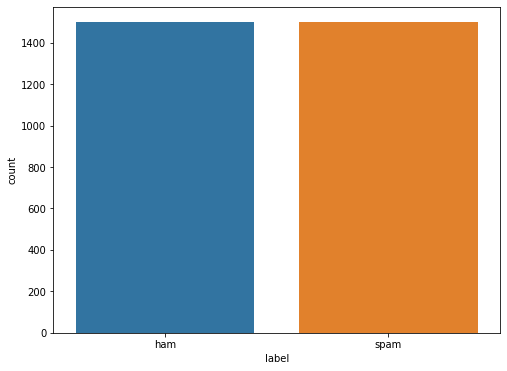

In [184]:
ham_messages_downsample = ham_message_df.sample(n = len(spam_message_df), random_state =44)
print(ham_messages_downsample.shape, spam_message_df.shape)
plt.figure(figsize=(8,6))
df_downsampled=ham_messages_downsample.append(spam_message_df).reset_index(drop=True)
sns.countplot(df_downsampled.label)

In [185]:
df_downsampled

,label,text,label_num
0,ham,natural gas nomination for 5 / 01 enron met...,0
1,ham,interview schedule for liz bellamy - today ...,0
2,ham,mgi supply - - - - - - - - - - - - - - - - ...,0
3,ham,- - - - - - - - - - - - - - - - - - - - - - ...,0
4,ham,clickathome portal is here ! version 2 . 0 ...,0
...,...,...,...
2993,spam,pictures streamlined denizen ajar chased h...,1
2994,spam,penny stocks are about timing nomad interna...,1
2995,spam,anomaly boys from 3881 uosda apaproved mled...,1
2996,spam,slutty milf wants to meet you take that ! ...,1


In [186]:
Y = df_downsampled['label_num'].values
x_train,x_test,y_train,y_test=train_test_split(df_downsampled['text'],Y,test_size=0.33)
MAX_VOCAB_SIZE = 20000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train=tokenizer.texts_to_sequences(x_train)
sequences_test=tokenizer.texts_to_sequences(x_test)
tokenidx = tokenizer.word_index
V = len(tokenidx)
x_train_pad=pad_sequences(sequences_train)
T=x_train_pad.shape[1]
x_test_pad=pad_sequences(sequences_test, maxlen=T)

#embedding dimension vectors and indexing the vector
D=20

#Hidden vector M
M=15

i=Input(shape=(T,))

#V+1 as 0th place is not used due to value for missing tokens
X=Embedding(V+1,D)(i)
X=LSTM(M,return_sequences=True)(X)
X=GlobalMaxPooling1D()(X)
x=Dropout(0.2)(X)
X=Dense(1,activation='sigmoid')(X)

model=Model(i,X)

In [187]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
r=model.fit(x_train_pad,y_train,validation_data=(x_test_pad,y_test),epochs=10)

Epoch 1/10
63/63 [==============================] - 18s 260ms/step - loss: 0.6388 - accuracy: 0.6748 - val_loss: 0.4811 - val_accuracy: 0.9303
Epoch 2/10
63/63 [==============================] - 16s 251ms/step - loss: 0.5810 - accuracy: 0.7993 - val_loss: 0.4803 - val_accuracy: 0.7556
Epoch 3/10
63/63 [==============================] - 16s 251ms/step - loss: 0.4105 - accuracy: 0.8974 - val_loss: 0.3659 - val_accuracy: 0.9192
Epoch 4/10
63/63 [==============================] - 16s 251ms/step - loss: 0.3074 - accuracy: 0.9482 - val_loss: 0.2887 - val_accuracy: 0.9414
Epoch 5/10
63/63 [==============================] - 16s 251ms/step - loss: 0.2334 - accuracy: 0.9831 - val_loss: 0.2298 - val_accuracy: 0.9677
Epoch 6/10
63/63 [==============================] - 16s 250ms/step - loss: 0.1773 - accuracy: 0.9915 - val_loss: 0.1845 - val_accuracy: 0.9798
Epoch 7/10
63/63 [==============================] - 16s 252ms/step - loss: 0.1349 - accuracy: 0.9950 - val_loss: 0.1503 - val_accuracy: 0.9818

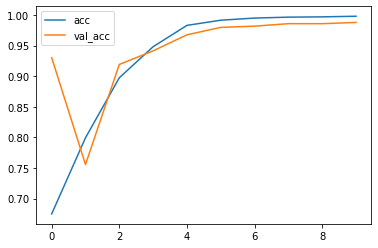

In [188]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

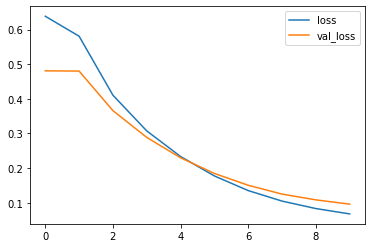

In [189]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [190]:
model.evaluate(x_test_pad, y_test)

31/31 [==============================] - 4s 114ms/step - loss: 0.0957 - accuracy: 0.9879


[0.09571070969104767, 0.9878787994384766]

In [191]:
predict_msg = ["DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt"]

In [192]:
predict_spam(predict_msg)

 Message: DHL: * Your order # 07u # will * reach you shortly. https://hakurei-shrine.icu/0/?ew8e1um.cnt


'This message is a: Spam'

# **Upsampling**

In [193]:
int(len(ham_message_df)/2)

1836

(3672, 3) (3672, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


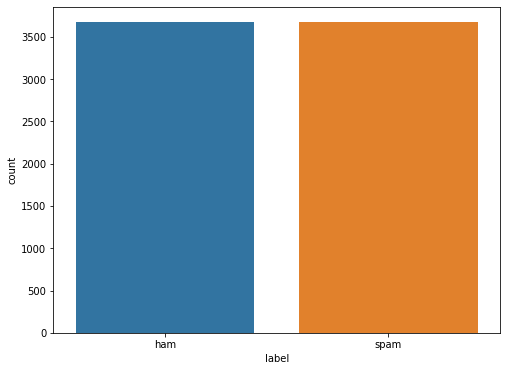

In [194]:
spam_messages_upsample = spam_message_df.sample(n = len(ham_message_df), random_state =44,replace=True)
print(ham_message_df.shape, spam_messages_upsample.shape)
plt.figure(figsize=(8,6))
df_upsampled=ham_message_df.append(spam_messages_upsample).reset_index(drop=True)
sns.countplot(df_upsampled.label)

In [195]:
Y = df_upsampled['label_num'].values
x_train,x_test,y_train,y_test=train_test_split(df_upsampled['text'],Y,test_size=0.33)
MAX_VOCAB_SIZE = 20000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train=tokenizer.texts_to_sequences(x_train)
sequences_test=tokenizer.texts_to_sequences(x_test)
tokenidx = tokenizer.word_index
V = len(tokenidx)
x_train_pad=pad_sequences(sequences_train)
T=x_train_pad.shape[1]
x_test_pad=pad_sequences(sequences_test, maxlen=T)

#embedding dimension vectors and indexing the vector
D=20

#Hidden vector M
M=15

i=Input(shape=(T,))

#V+1 as 0th place is not used due to value for missing tokens
X=Embedding(V+1,D)(i)
X=LSTM(M,return_sequences=True)(X)
X=GlobalMaxPooling1D()(X)
x=Dropout(0.2)(X)
X=Dense(1,activation='sigmoid')(X)

model=Model(i,X)

In [196]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
r=model.fit(x_train_pad,y_train,validation_data=(x_test_pad,y_test),epochs=10)

Epoch 1/10
154/154 [==============================] - 43s 261ms/step - loss: 0.5226 - accuracy: 0.7848 - val_loss: 0.2172 - val_accuracy: 0.9785
Epoch 2/10
154/154 [==============================] - 39s 254ms/step - loss: 0.1465 - accuracy: 0.9803 - val_loss: 0.0947 - val_accuracy: 0.9864
Epoch 3/10
154/154 [==============================] - 39s 251ms/step - loss: 0.0756 - accuracy: 0.9900 - val_loss: 0.0678 - val_accuracy: 0.9884
Epoch 4/10
154/154 [==============================] - 39s 251ms/step - loss: 0.0460 - accuracy: 0.9945 - val_loss: 0.0581 - val_accuracy: 0.9889
Epoch 5/10
154/154 [==============================] - 39s 251ms/step - loss: 0.0459 - accuracy: 0.9904 - val_loss: 0.0646 - val_accuracy: 0.9880
Epoch 6/10
154/154 [==============================] - 39s 251ms/step - loss: 0.0308 - accuracy: 0.9965 - val_loss: 0.0615 - val_accuracy: 0.9880
Epoch 7/10
154/154 [==============================] - 39s 252ms/step - loss: 0.0217 - accuracy: 0.9980 - val_loss: 0.0658 - val_ac

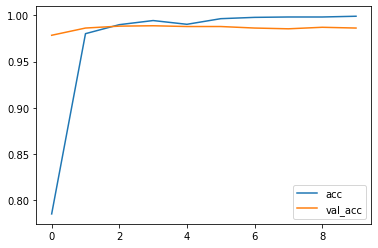

In [197]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

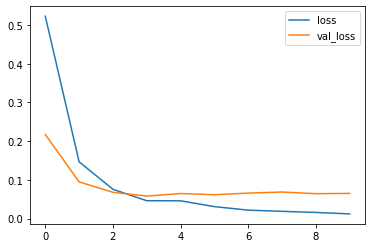

In [198]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [199]:
model.evaluate(x_test_pad, y_test)

76/76 [==============================] - 7s 97ms/step - loss: 0.0650 - accuracy: 0.9864


[0.0650063306093216, 0.9863861203193665]

In [200]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =T)
    return (model.predict(padded))
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "I am going for dinner. ",
          "What's up?"]
predict_spam(predict_msg)

array([[0.9747127 ],
       [0.35894004],
       [0.66504514]], dtype=float32)

It is observed that the LSTM with upsampling of dataset gives the best accuracy of 99% and a loss of  0.047.

## **biLSTM**

Testing biLSTM with upsampled dataset

In [201]:
from tensorflow.keras.layers import Bidirectional
Y = df_upsampled['label_num'].values
x_train,x_test,y_train,y_test=train_test_split(df_upsampled['text'],Y,test_size=0.33)
MAX_VOCAB_SIZE = 20000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
sequences_train=tokenizer.texts_to_sequences(x_train)
sequences_test=tokenizer.texts_to_sequences(x_test)
tokenidx = tokenizer.word_index
V = len(tokenidx)
x_train_pad=pad_sequences(sequences_train)
T=x_train_pad.shape[1]
x_test_pad=pad_sequences(sequences_test, maxlen=T)

#embedding dimension vectors and indexing the vector
D=20

#Hidden vector M
M=15

i=Input(shape=(T,))

#V+1 as 0th place is not used due to value for missing tokens
X=Embedding(V+1,D)(i)
X=Bidirectional(LSTM(M,return_sequences=True))(X)
X=GlobalMaxPooling1D()(X)
x=Dropout(0.2)(X)
X=Dense(1,activation='sigmoid')(X)

model=Model(i,X)

In [202]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
r=model.fit(x_train_pad,y_train,validation_data=(x_test_pad,y_test),epochs=10)

Epoch 1/10
154/154 [==============================] - 120s 753ms/step - loss: 0.4468 - accuracy: 0.8130 - val_loss: 0.1272 - val_accuracy: 0.9587
Epoch 2/10
154/154 [==============================] - 114s 739ms/step - loss: 0.0718 - accuracy: 0.9791 - val_loss: 0.0651 - val_accuracy: 0.9847
Epoch 3/10
154/154 [==============================] - 114s 744ms/step - loss: 0.0320 - accuracy: 0.9929 - val_loss: 0.0479 - val_accuracy: 0.9860
Epoch 4/10
154/154 [==============================] - 114s 741ms/step - loss: 0.0160 - accuracy: 0.9967 - val_loss: 0.0397 - val_accuracy: 0.9872
Epoch 5/10
154/154 [==============================] - 114s 740ms/step - loss: 0.0099 - accuracy: 0.9974 - val_loss: 0.0392 - val_accuracy: 0.9880
Epoch 6/10
154/154 [==============================] - 114s 740ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.0397 - val_accuracy: 0.9905
Epoch 7/10
154/154 [==============================] - 114s 740ms/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.0485 -

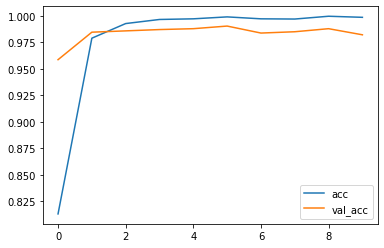

In [203]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

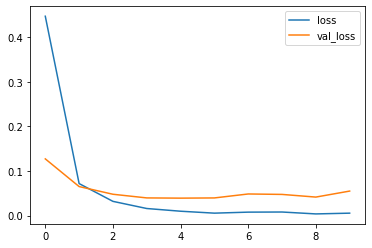

In [204]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [205]:
model.evaluate(x_test_pad, y_test)

76/76 [==============================] - 22s 288ms/step - loss: 0.0550 - accuracy: 0.9823


[0.055020179599523544, 0.9822607040405273]

In [206]:
predict_spam(predict_msg)

array([[0.9969927 ],
       [0.10374096],
       [0.99159676]], dtype=float32)

# **Conclusion**

It is observed that an LSTM algorithm with a dropout layer and upsampling results in best accuracy for the given task. This doesn't mean that other algorithms fail to do their task. But for my given parameters and dataset, the LSTM layer with upsampling and hyperparameters added works the best.